In [1]:
import Pkg; 

if split(pwd(),"/")[end] == "notebooks"
    cd(joinpath(@__DIR__, "../"))
    Pkg.activate("Project.toml")
end

using MorphoMol

using CairoMakie
using LinearAlgebra
using Random
using Rotations
using StaticArrays

  Activating project at `~/Desktop/Doktor/MorphoMolMonteCarlo`


In [3]:
function rotating_needle_energy_gradient!(∇E,x,v,w)
    R = exp(Rotations.RotationVecGenerator(x...))
    ∇E[1] = 0.5 * (-v[2]*(R[3,:] ⋅ w) + v[3]*(R[2,:] ⋅ w))
    ∇E[2] = 0.5 * (v[1]*(R[3,:] ⋅ w) - v[3]*(R[1,:] ⋅ w))
    ∇E[3] = 0.5 * (-v[1]*(R[2,:] ⋅ w) + v[2]*(R[1,:] ⋅ w))
    ∇E
end

rotating_needle_energy_gradient! (generic function with 1 method)

In [4]:
# v = direction of maximum energy
# w = template orientation
function rotating_needle_energy(x, v, w)
    v ⋅ (exp(Rotations.RotationVecGenerator(x...)) * w)
end

rotating_needle_energy (generic function with 1 method)

In [5]:
T = 0.25
ε = 0.1
p = [0.0, 0.0, 0.0]
L = 5
β = 1.0 / T

σ = 0.5
draw_perturbation = () -> σ * randn(3)
inner_product = (p) -> (p ⋅ p)

v = [1.0, 0.0, 0.0] # direction of maximum energy
w = [1.0, 0.0, 0.0] # initial state

energy(x) = rotating_needle_energy(x, v, w)
energy_gradient!(∇E, x) = rotating_needle_energy_gradient!(∇E, x, v, w)
position_leapfrog(ε, p, x) = ε * p + x

hmc = MorphoMol.Algorithms.HamiltonianMonteCarlo(energy, energy_gradient!, inner_product, draw_perturbation, position_leapfrog, β, L, ε)
x = rand(3) .* pi
p = [0.0, 0.0, 0.0]
iterations = 100000
states, accepted_steps = MorphoMol.Algorithms.simulate!(hmc, x, p, iterations);
state_coordinates = [exp(Rotations.RotationVecGenerator(x...)) * w for x in states]
xs = [c[1] for c in state_coordinates]
ys = [c[2] for c in state_coordinates]
zs = [c[3] for c in state_coordinates];
accepted_steps / iterations

0.84083

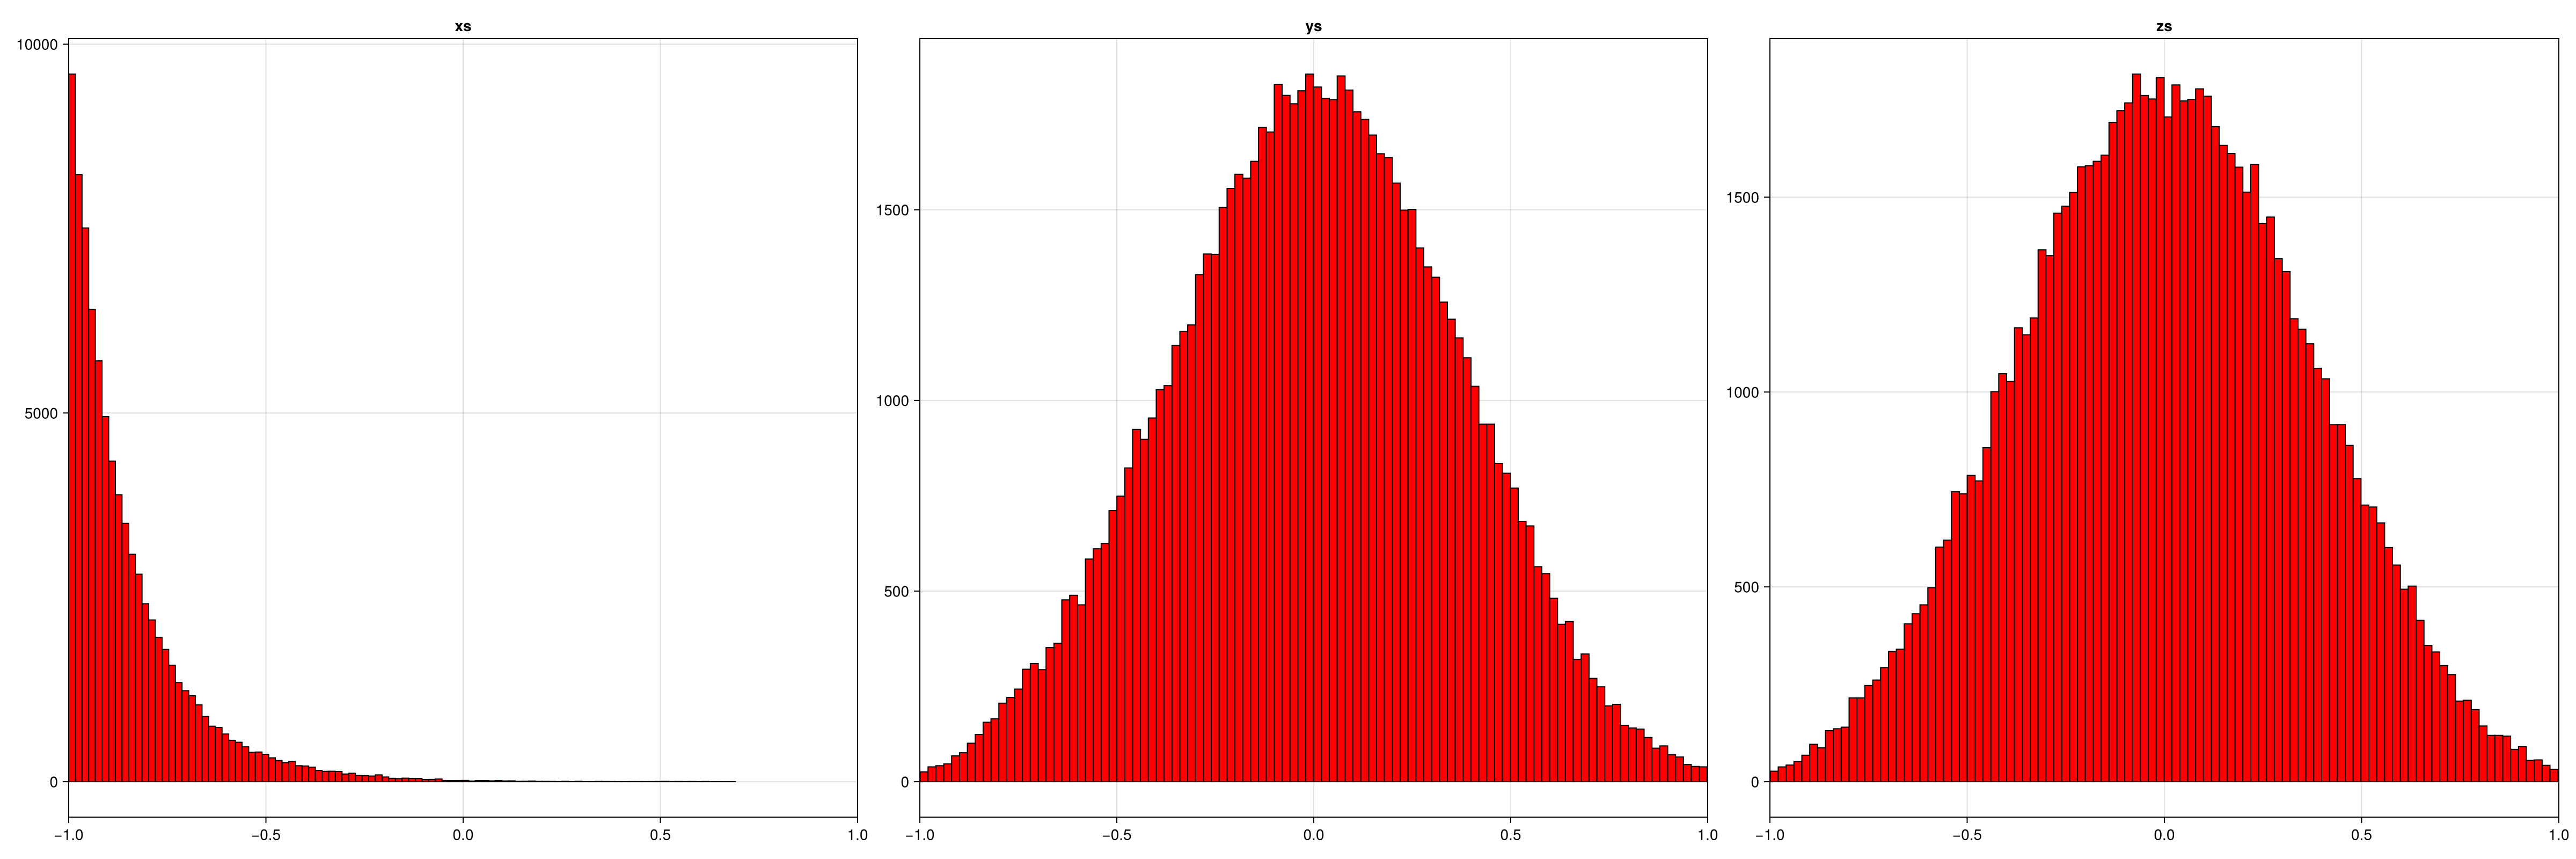

In [6]:
f = Figure(size = (2400, 800))
bin_number = 100
hist(f[1, 1], xs, bins = bin_number, color = :red, strokewidth = 1, strokecolor = :black, axis = (title = "xs", limits = ((-1.0, 1.0), nothing),))
hist(f[1, 2], ys, bins = bin_number, color = :red, strokewidth = 1, strokecolor = :black, axis = (title = "ys", limits = ((-1.0, 1.0), nothing),))
hist(f[1, 3], zs, bins = bin_number, color = :red, strokewidth = 1, strokecolor = :black, axis = (title = "zs", limits = ((-1.0, 1.0), nothing),))
f